In [31]:
import re
import math
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import matplotlib.pyplot as plt

In [20]:
PATH_PACKAGING = "/Users/niharikadeokar/Desktop/ECOZE/packaging.csv"   # 30-row table (from your screenshot)
PATH_MAIN      = "/Users/niharikadeokar/Desktop/ECOZE/main_dataset.csv"  # your master catalog (75,900 rows)

# Load
pack = pd.read_csv(PATH_PACKAGING)
main = pd.read_csv(PATH_MAIN)

# Peek
print(pack.columns.tolist())
print(main.columns.tolist())

['use_category', 'Name', 'Average quantity/per use', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'total_cf', 'Number of Uses per Product', 'cf_per_use', 'cf_of_average_product_per_use_g', 'packaging_cf_kg', 'cf_of_average_product_packaging_per_use_g']
['name', 'description', 'department', 'aisle', 'shelf', 'recycling_info', 'store', 'tesco_department', 'ecoze_category']


/var/folders/97/2wp359315j1fwr4xv957wy880000gn/T/ipykernel_41474/3827044947.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  main = pd.read_csv(PATH_MAIN)


In [21]:
pack.head(1)

,use_category,Name,Average quantity/per use,Unnamed: 3,Unnamed: 4,Unnamed: 5,total_cf,Number of Uses per Product,cf_per_use,cf_of_average_product_per_use_g,packaging_cf_kg,cf_of_average_product_packaging_per_use_g
0,Hand Washing,Carex Handwash 250ml,2.5,NaN,NaN,NaN,12.5,100.0,0.13,125.0,0.095333,0.953333


In [22]:
main.sample(1)

,name,description,department,aisle,shelf,recycling_info,store,tesco_department,ecoze_category
67745,Fruit Shoot Apple & Blackcurrant Kids Juice Drink 15 x 200ml,"IngredientsWater, Fruit Juices from Concentrate (Apple 6%, Blackcurrant 2%), Acid (Citric Acid), Natural Flavourings, Acidity Regulator (Sodium Citrate), Carrot and Blueberry Concentrate, Antioxid...",Drinks,Kids & Lunchbox Drinks,NaN,NaN,Iceland,Drinks,NaN


In [23]:
pack = pack.rename(columns={
    "use_category": "use_category",
    "Name": "ref_name",
    "cf_of_average_product_packaging_per_use_g": "cf_per_use_g"
})
main = main.rename(columns={
    "ecoze_category": "ecoze_category",
    "name": "prod_name"
})

# === STEP 4: Normalize category names
def norm(s):
    if pd.isna(s): return None
    return re.sub(r"\s+", " ", str(s).strip().lower())

pack["use_category_norm"] = pack["use_category"].map(norm)
main["use_category_norm"] = main["ecoze_category"].map(norm)

# === STEP 5: (Optional) filter categories to ignore
IGNORE_CATS = {"food"}
main = main[~main["use_category_norm"].isin(IGNORE_CATS)].copy()

# === STEP 6: Size extraction function
NUM = r"(\d+(?:\.\d+)?)"
SP = r"\s*"
xMULT = r"(?:x|×|\*)"
unit_re = re.compile(
    rf"(?P<count1>{NUM}){SP}{xMULT}{SP}(?P<count2>{NUM}){SP}(?P<u2>ml|l|g|kg)\b"
    r"|(?P<count_only>(?:pack\s*of|pk|pack)\s*" + NUM + r")\b"
    r"|(?P<val>" + NUM + r")" + SP + r"(?P<u>ml|l|g|kg)\b",
    flags=re.I
)

def parse_size(text):
    if not isinstance(text, str):
        return {"qty_count": None, "size_ml": None, "size_g": None}
    t = text.lower()
    qty_count, size_ml, size_g = None, None, None
    for m in unit_re.finditer(t):
        if m.group("count1") and m.group("count2") and m.group("u2"):
            c = float(m.group("count1"))
            v = float(m.group("count2"))
            u = m.group("u2").lower()
            qty_count = max(qty_count or 0, int(round(c)))
            if u == "ml": size_ml = max(size_ml or 0, c*v)
            elif u == "l":  size_ml = max(size_ml or 0, c*v*1000)
            elif u == "g":  size_g = max(size_g or 0, c*v)
            elif u == "kg": size_g = max(size_g or 0, c*v*1000)
        elif m.group("count_only"):
            q = re.findall(NUM, m.group("count_only"))
            if q: qty_count = max(qty_count or 0, int(float(q[-1])))
        elif m.group("val") and m.group("u"):
            v = float(m.group("val"))
            u = m.group("u").lower()
            if u == "ml": size_ml = max(size_ml or 0, v)
            elif u == "l":  size_ml = max(size_ml or 0, v*1000)
            elif u == "g":  size_g = max(size_g or 0, v)
            elif u == "kg": size_g = max(size_g or 0, v*1000)
    return {"qty_count": qty_count, "size_ml": size_ml, "size_g": size_g}

# === STEP 7: Parse sizes in both datasets
pack_size = pack["ref_name"].map(parse_size).apply(pd.Series).add_prefix("ref_")
main_size = main["prod_name"].map(parse_size).apply(pd.Series)

pack = pd.concat([pack, pack_size], axis=1)
main = pd.concat([main, main_size], axis=1)

# === STEP 8: Define preferred size unit per category
UNIT_PREFERENCE = {
    "hand washing": "ml",
    "whole body cleansing": "ml",
    "hair conditioner": "ml",
    "saving foam": "ml",
    "shaver": "count",
    "dental mouth wash": "ml",
    "dental toothpaste": "g",
    "toothbrush": "count",
    "hair styling": "ml",
    "deodorant": "ml",
    "moisturiser": "ml",
}

def canonical_size(row, cat_col, prefix=""):
    cat = row.get(cat_col)
    pref = UNIT_PREFERENCE.get(cat, "ml")
    if pref == "ml":    return row.get(prefix + "size_ml")
    if pref == "g":     return row.get(prefix + "size_g")
    if pref == "count": return row.get(prefix + "qty_count")
    return row.get(prefix + "size_ml") or row.get(prefix + "size_g") or row.get(prefix + "qty_count")

pack["ref_size"] = pack.apply(lambda r: canonical_size(r, "use_category_norm", "ref_"), axis=1)
main["prod_size"] = main.apply(lambda r: canonical_size(r, "use_category_norm", ""), axis=1)

# === STEP 9: Merge and estimate CF
pack_small = (
    pack.sort_values("ref_size", ascending=True)
        .drop_duplicates("use_category_norm")
        [["use_category_norm", "cf_per_use_g", "ref_name", "ref_size"]]
)

merged = main.merge(pack_small, on="use_category_norm", how="left")

# === STEP 10: Scale carbon footprint
def scale_cf(base_cf, prod_size, ref_size, mode="per_use_linear"):
    if pd.isna(base_cf) or base_cf <= 0: return np.nan
    if mode in ("none", "constant"): return base_cf
    if pd.isna(prod_size) or pd.isna(ref_size) or ref_size <= 0: return base_cf
    ratio = float(prod_size) / float(ref_size)
    if ratio <= 0: return base_cf
    if mode == "per_use_linear": return base_cf * ratio
    if mode == "inverse_if_constant_packaging": return base_cf / ratio
    return base_cf

merged["packaging_cf_per_use_g_est"] = merged.apply(
    lambda r: scale_cf(r["cf_per_use_g"], r["prod_size"], r["ref_size"]), axis=1
)

# === STEP 11: Confidence label
merged["packaging_cf_confidence"] = np.where(
    merged["cf_per_use_g"].isna(), "no_category_match",
    np.where(
        merged["prod_size"].notna() & merged["ref_size"].notna(),
        "scaled:per_use_linear",
        "category_average"
    )
)

# === STEP 12: Save result
merged.to_csv("output_with_packaging_cf.csv", index=False)
print("✅ File saved: output_with_packaging_cf.csv")

# === STEP 13: Optional summary
print("\n--- Summary ---")
print("Rows total:", len(merged))
print("Rows with estimated CF:", merged["packaging_cf_per_use_g_est"].notna().sum())
print("\nConfidence breakdown:")
print(merged["packaging_cf_confidence"].value_counts())


✅ File saved: output_with_packaging_cf.csv

--- Summary ---
Rows total: 40596
Rows with estimated CF: 14722

Confidence breakdown:
no_category_match        25874
category_average         10939
scaled:per_use_linear     3783
Name: packaging_cf_confidence, dtype: int64


In [28]:
merged.sample(3)

,prod_name,description,department,aisle,shelf,recycling_info,store,tesco_department,ecoze_category,use_category_norm,qty_count,size_ml,size_g,prod_size,cf_per_use_g,ref_name,ref_size,packaging_cf_per_use_g_est,packaging_cf_confidence
13189,Veetee Heat& Eat Long Grain Rice Pots x2 260g,"\n\nLong Grain\n\n\nPerfectly Fluffy\nEnjoy Now, Enjoy Later\nMicrowave or stir fry for 1 min\nSteamed, Not Stodgy!\n\n\n\nVeetee rice is cooked using our unique Steam Filtered™ process, giving yo...",Food cupboard,"Rice, pasta & noodles",All,Country of origin: United Kingdom,Sainsbury's,Food Cupboard,Non-Alcoholic Cold Drinks,non-alcoholic cold drinks,NaN,NaN,260.0,NaN,0.381333,San Pellegrino Sparkling Water 500Ml (New),500.0,0.381333,category_average
15461,Players JPS Real Red 5x20 Cigarettes,\n\n\nManufactured in the EU by Imperial Tobacco Limited.,Homeware & outdoor,Newsagent & tobacconist,Cigarettes,NaN,Sainsbury's,Home & Ents,Alcohol,alcohol,NaN,NaN,NaN,NaN,114.400000,Carling Lager 18X440ml,7920.0,114.400000,category_average
25089,Kellogg's Coco Pops Chocolate Breakfast Cereal Bars,NaN,NaN,NaN,NaN,NaN,Morrisons,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_category_match


TypeError: 'value' must be an instance of str or bytes, not a float

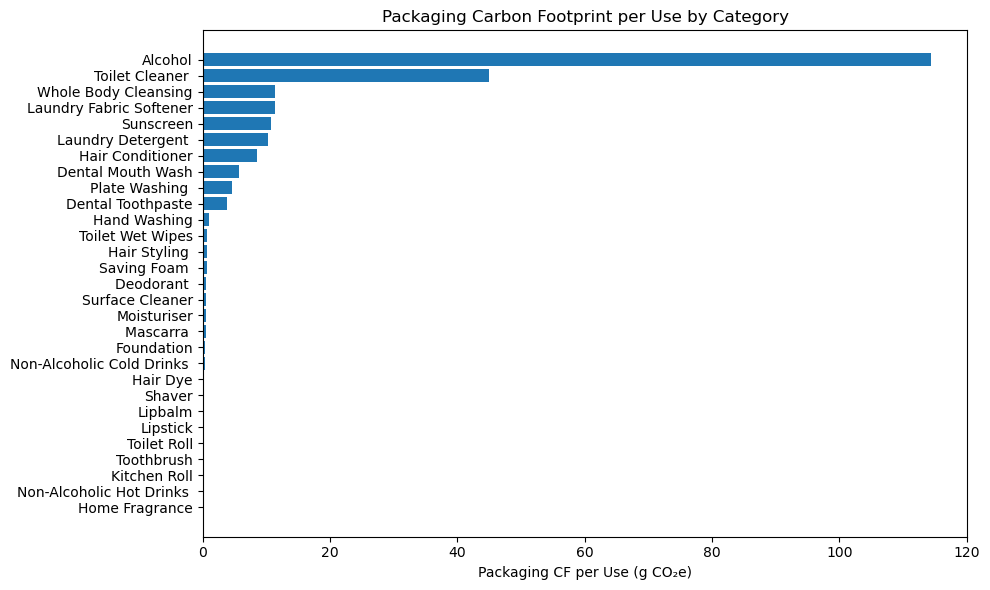

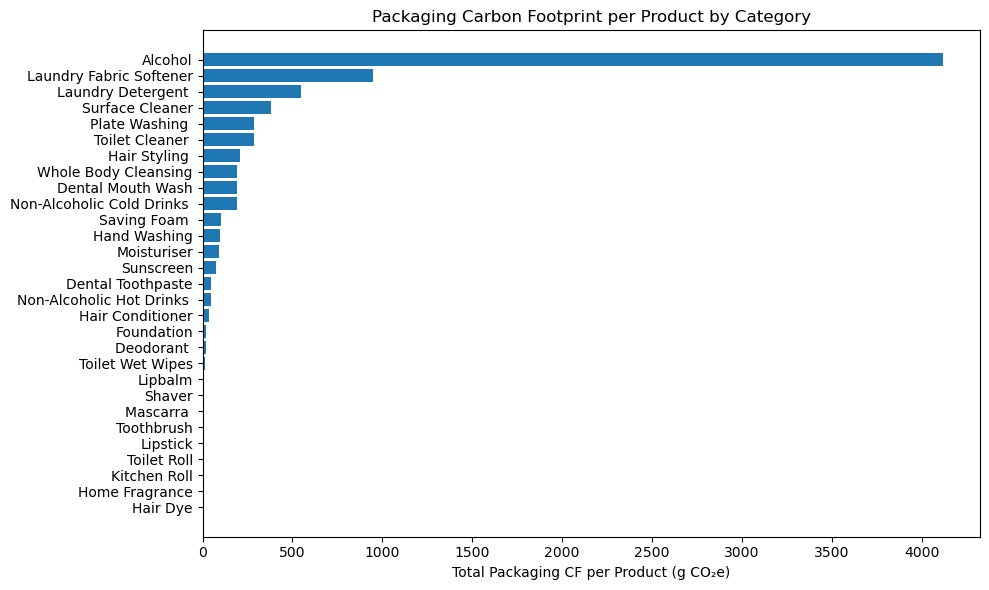

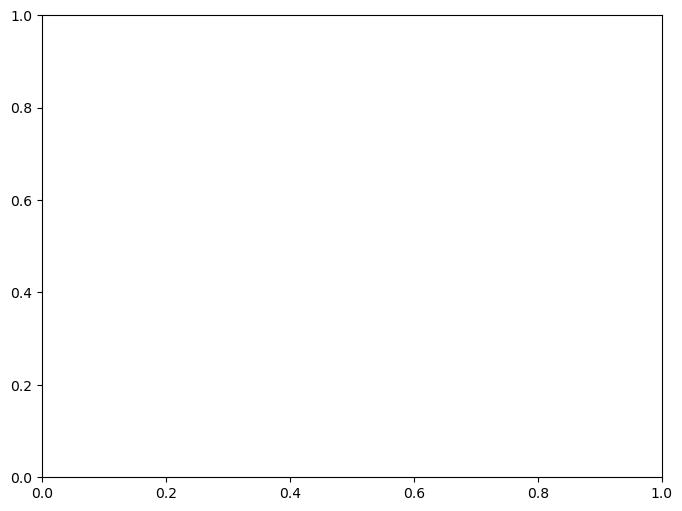

In [ ]:
pack.columns = [col.strip().lower().replace(" ", "_") for col in pack.columns]

pack = pack.rename(columns={
    "cf_of_average_product_packaging_per_use_g": "cf_per_use_g",
    "packaging_cf__kg": "packaging_cf_kg"
})

# Sort by highest CF per use
cf_sorted = pack.sort_values("cf_per_use_g", ascending=False)

# === Plot 1: Packaging CF per Use by Category
plt.figure(figsize=(10, 6))
plt.barh(cf_sorted["use_category"], cf_sorted["cf_per_use_g"])
plt.xlabel("Packaging CF per Use (g CO₂e)")
plt.title("Packaging Carbon Footprint per Use by Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("packaging_cf_per_use_by_category.png", dpi=300)

# === Plot 2: Packaging CF per Product
plt.figure(figsize=(10, 6))
pack["cf_total_g"] = pack["packaging_cf_kg"] * 1000  # convert kg → g
cf_total_sorted = pack.sort_values("cf_total_g", ascending=False)
plt.barh(cf_total_sorted["use_category"], cf_total_sorted["cf_total_g"])
plt.xlabel("Total Packaging CF per Product (g CO₂e)")
plt.title("Packaging Carbon Footprint per Product by Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("packaging_cf_total_by_category.png", dpi=300)


print("✅ Charts saved:")
print("- packaging_cf_per_use_by_category.png")
print("- packaging_cf_total_by_category.png")
print("- quantity_vs_cf_per_use.png")


/var/folders/97/2wp359315j1fwr4xv957wy880000gn/T/ipykernel_41474/2507743338.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/code/output_with_packaging_cf.csv")


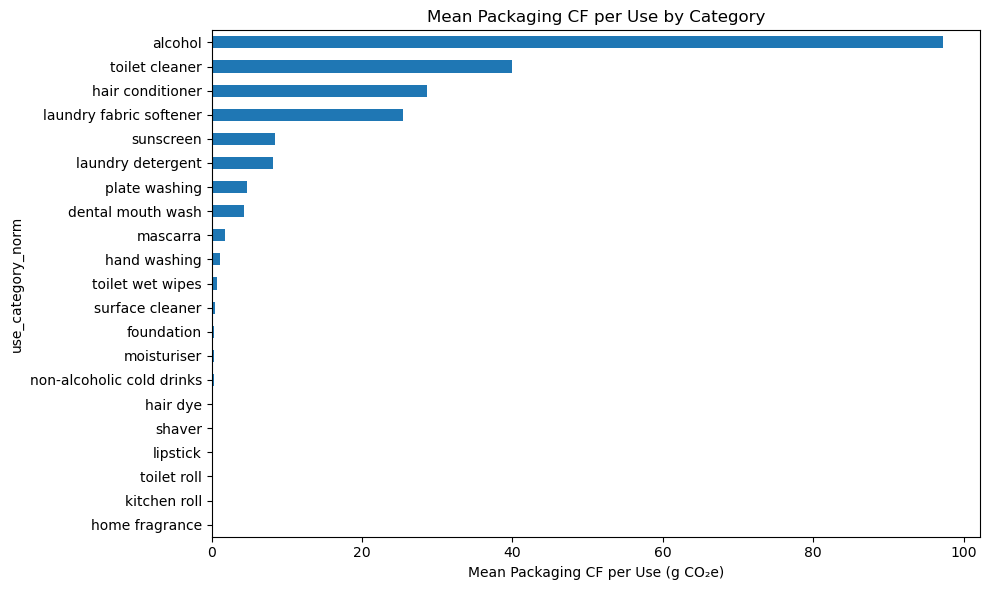

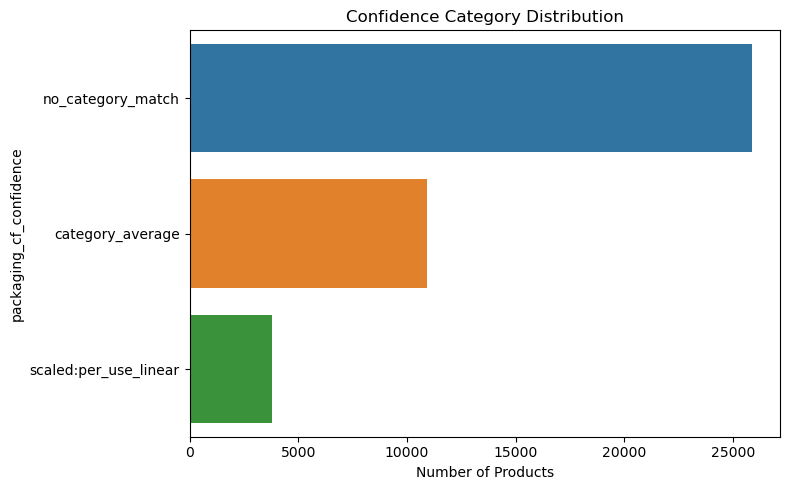

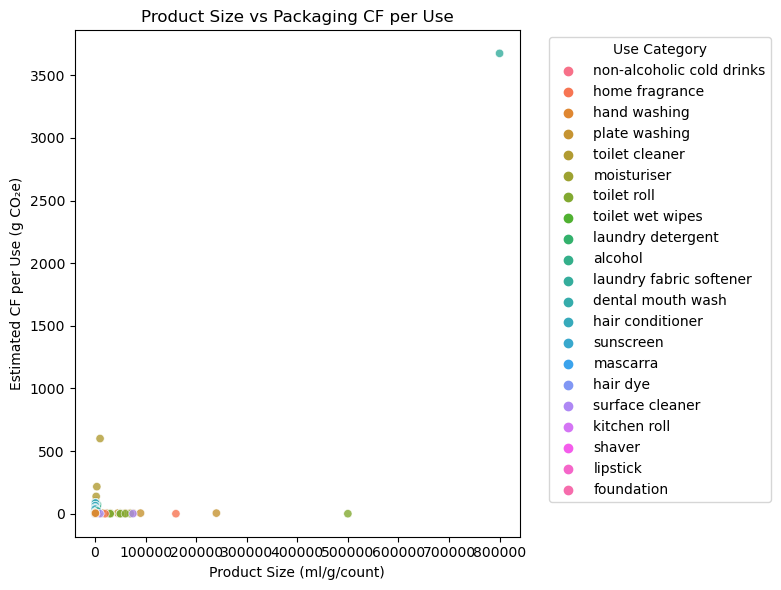

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your processed CSV
df = pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/code/output_with_packaging_cf.csv")

# Ensure the right columns are present
cols_needed = [
    "use_category_norm", "prod_size", "ref_size", "cf_per_use_g",
    "packaging_cf_per_use_g_est", "packaging_cf_confidence"
]
assert all(col in df.columns for col in cols_needed), "Some required columns are missing."

# Optional: Drop rows with missing CF estimates
df_clean = df.dropna(subset=["packaging_cf_per_use_g_est"])

# === 1. Bar chart: Mean packaging CF per use by category
mean_cf = (
    df_clean
    .groupby("use_category_norm")["packaging_cf_per_use_g_est"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
mean_cf.plot(kind="barh")
plt.xlabel("Mean Packaging CF per Use (g CO₂e)")
plt.title("Mean Packaging CF per Use by Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("mean_cf_per_use_by_category.png", dpi=300)
plt.show()

# === 2. Distribution: Scaled vs. Average vs. Missing CF
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    y="packaging_cf_confidence",
    order=df["packaging_cf_confidence"].value_counts().index
)
plt.title("Confidence Category Distribution")
plt.xlabel("Number of Products")
plt.tight_layout()
plt.savefig("cf_confidence_breakdown.png", dpi=300)
plt.show()

# === 3. Scatter: Product Size vs Estimated Packaging CF per Use
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clean,
    x="prod_size",
    y="packaging_cf_per_use_g_est",
    hue="use_category_norm",
    alpha=0.8
)
plt.title("Product Size vs Packaging CF per Use")
plt.xlabel("Product Size (ml/g/count)")
plt.ylabel("Estimated CF per Use (g CO₂e)")
plt.legend(title="Use Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("size_vs_cf_per_use.png", dpi=300)
plt.show()